In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np

# Input file paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
envi_raster_path = "non_provisional_flightlines/NEON_D13_NIWO_DP1_20200801_155424_reflectance/NEON_D13_NIWO_DP1_20200801_155424_reflectance"
output_masked_raster_path = "masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat"

# Load the GeoJSON file with polygons
polygons = gpd.read_file(geojson_path)

# Open the ENVI raster file
with rasterio.open(envi_raster_path) as src:
    # Read the metadata and data
    meta = src.meta.copy()
    raster_data = src.read(1)  # Assuming single-band raster, adjust if multi-band
    
    # Create a mask based on the GeoJSON polygons
    mask = geometry_mask(
        [geom for geom in polygons.geometry],
        transform=src.transform,
        invert=True,  # Keep pixels inside the polygons
        out_shape=(src.height, src.width),
    )
    
    # Apply the mask to the raster data
    masked_raster = np.where(mask, raster_data, np.nan)  # Set masked areas to NaN

# Update metadata for the output raster
meta.update(dtype='float32', nodata=np.nan)

# Save the masked raster to a new ENVI file
with rasterio.open(output_masked_raster_path, 'w', **meta) as dst:
    dst.write(masked_raster.astype('float32'), 1)

print(f"Masked raster saved to {output_masked_raster_path}")


Masked raster saved to masked_NEON_D13_NIWO_DP1_20200801_155424_reflectance.dat


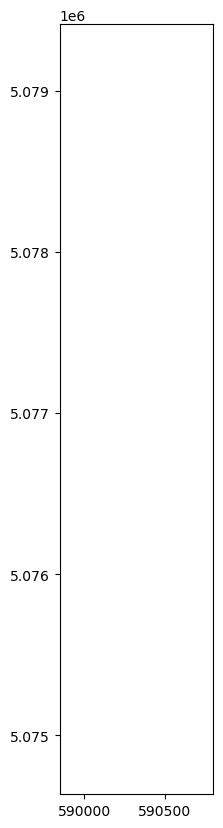

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

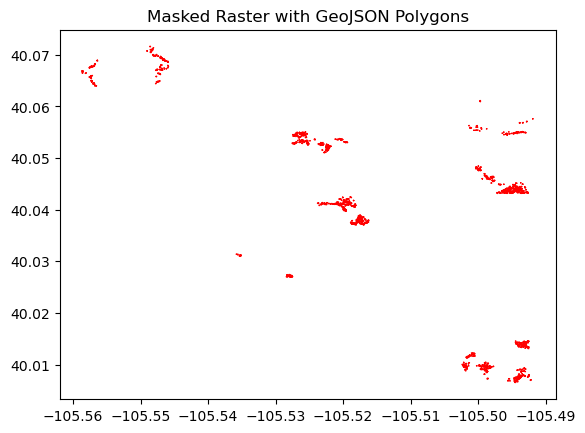

In [14]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

# File paths
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
masked_raster_path = "non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2_masked"

# Load the GeoJSON file
polygons = gpd.read_file(geojson_path)

# Open the masked raster file
with rasterio.open(masked_raster_path) as src:
    # Read the first band for visualization (adjust if needed)
    raster_data = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 10))
    show(raster_data, transform=src.transform, cmap="viridis")
    plt.title("Masked Raster with GeoJSON Polygons")
    
    # Overlay the polygons
    for geom in polygons.geometry:
        if not geom.is_empty:
            x, y = geom.exterior.xy  # Extract exterior boundary of the polygon
            plt.plot(x, y, color="red", linewidth=1, label="Polygon Overlay")
    
    # Add legend and display
    plt.legend(["GeoJSON Polygons"])
    plt.show()


In [13]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import geometry_mask

def find_reference_envi_file(envi_files, derived_file):
    """
    Finds the reference __envi file for a given derived file.

    Parameters:
    - envi_files (list): List of all __envi files in the folder.
    - derived_file (str): The derived file (e.g., .img) for which to find the reference.

    Returns:
    - str: Path to the reference __envi file, or None if not found.
    """
    base_name = os.path.basename(derived_file).split("_resample")[0]
    for envi_file in envi_files:
        if base_name in envi_file:
            return envi_file
    return None

def apply_mask_to_envi_files(folder_path, geojson_path, suffix='_masked'):
    """
    Applies a mask to all ENVI files (including .img files) in a folder and saves
    the masked output next to the original files, excluding the .img extension.

    Parameters:
    - folder_path (str): Path to the folder containing ENVI files.
    - geojson_path (str): Path to the GeoJSON file with polygons for masking.
    - suffix (str): Suffix to append to the masked file names.
    """
    # Load polygons from GeoJSON
    polygons = gpd.read_file(geojson_path)

    # Find ENVI files including those with .img extensions
    envi_files = glob.glob(os.path.join(folder_path, '*_envi'))
    derived_files = glob.glob(os.path.join(folder_path, '*.img'))
    all_files = envi_files + derived_files

    if not all_files:
        print(f"No ENVI or .img files found in folder: {folder_path}")
        return

    print(f"Found {len(all_files)} file(s) to process in {folder_path}")

    for envi_file in all_files:
        try:
            print(f"Processing file: {envi_file}")

            # Open the ENVI file
            with rasterio.open(envi_file) as src:
                if envi_file.endswith('.img'):
                    # Find corresponding __envi file for georeferencing
                    reference_envi_file = find_reference_envi_file(envi_files, envi_file)
                    if reference_envi_file:
                        print(f"Adopting georeference from {reference_envi_file}")
                        with rasterio.open(reference_envi_file) as ref_src:
                            transform = ref_src.transform
                            crs = ref_src.crs
                    else:
                        print(f"Warning: No reference ENVI file found for {envi_file}. Using default georeference.")
                        transform = src.transform
                        crs = src.crs
                else:
                    transform = src.transform
                    crs = src.crs

                # Read metadata and data
                meta = src.meta.copy()
                meta.update(transform=transform, crs=crs)
                raster_data = src.read(1)  # Assuming single-band raster, adjust if multi-band

                # Create a mask based on GeoJSON polygons
                mask = geometry_mask(
                    [geom for geom in polygons.geometry],
                    transform=transform,
                    invert=True,  # Keep pixels inside the polygons
                    out_shape=(src.height, src.width),
                )

                # Apply the mask
                masked_data = np.where(mask, raster_data, np.nan)

            # Update metadata for the output file
            meta.update(dtype='float32', nodata=np.nan)

            # Define the output path, removing the .img extension if present
            base_name = os.path.splitext(envi_file)[0]
            output_file = f"{base_name}{suffix}"

            # Save the masked raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                dst.write(masked_data.astype('float32'), 1)

            print(f"Masked file saved to: {output_file}")

        except Exception as e:
            print(f"Error processing {envi_file}: {e}")


# Example Usage
folder_path = "non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance"
geojson_path = "aop_macrosystems_data_1_7_25.geojson"
apply_mask_to_envi_files(folder_path, geojson_path)


Found 8 file(s) to process in non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi
Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_5_TM.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_5_TM_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_7_ETMplus.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_7_ETMplus_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_8_OLI.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_8_OLI_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_9_OLI-2.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_Landsat_9_OLI-2_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_TM_and_ETMplus.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_TM_and_ETMplus_masked
Processing file: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2.img
Adopting georeference from non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi


/opt/conda/envs/macrosystems/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Masked file saved to: non_provisional_flightlines/NEON_D16_WREF_DP1_20210719_174212_reflectance/NEON_D16_WREF_DP1_20210719_174212_reflectance__envi_resample_MicaSense-to-match_OLI_and_OLI-2_masked


In [25]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box

def plot_preserved_polygons_with_extent_fix(envi_file, geojson_file, output_file=None):
    """
    Plots the flight line ENVI raster with only the polygons preserved after masking.
    Handles cases where polygon extent is larger than the raster extent.
    
    Parameters:
    - envi_file (str): Path to the ENVI raster file.
    - geojson_file (str): Path to the GeoJSON file containing polygons.
    - output_file (str): Optional. Path to save the plot as an image.
    """
    # Load polygons
    polygons = gpd.read_file(geojson_file)

    # Open the ENVI file
    with rasterio.open(envi_file) as src:
        raster_data = src.read(1)  # Assuming single-band raster
        raster_transform = src.transform
        raster_crs = src.crs
        raster_bounds = box(*src.bounds)

        # Ensure polygons are in the same CRS as the raster
        if polygons.crs != raster_crs:
            polygons = polygons.to_crs(raster_crs)
        
        # Clip polygons to the raster extent
        polygons = gpd.clip(polygons, raster_bounds)

        # Check for intersecting polygons
        preserved_polygons = polygons[polygons.geometry.apply(lambda geom: geom.intersects(raster_bounds))]
        if preserved_polygons.empty:
            print("No polygons intersect with the raster extent.")
            return

        # Mask the raster with the polygons
        masked_data, masked_transform = mask(src, preserved_polygons.geometry, crop=True, all_touched=True, nodata=np.nan)
        masked_data = masked_data[0]  # Extract the first (and likely only) band

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plot the masked raster
    show(masked_data, transform=masked_transform, ax=ax, cmap='gray', title="Preserved Polygons on ENVI Raster")
    
    # Plot preserved polygons
    preserved_polygons.boundary.plot(ax=ax, color='red', linewidth=1.5, label='Preserved Polygons')
    
    plt.legend()
    plt.tight_layout()

    # Save or show the plot
    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()



envi_file = "non_provisional_flightlines_NIWO/NEON_D13_NIWO_DP1_20200731_151902_reflectance/NEON_D13_NIWO_DP1_20200731_151902_reflectance__envi"
geojson_file = "aop_macrosystems_data_1_7_25.geojson"
output_file = "tester_output_plot.png"  # Optional

plot_preserved_polygons(envi_file, geojson_file, output_file)

ValueError: Input shapes do not overlap raster.

/tmp/ipykernel_700/1199563595.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


Plot saved to tester_output_plot.png


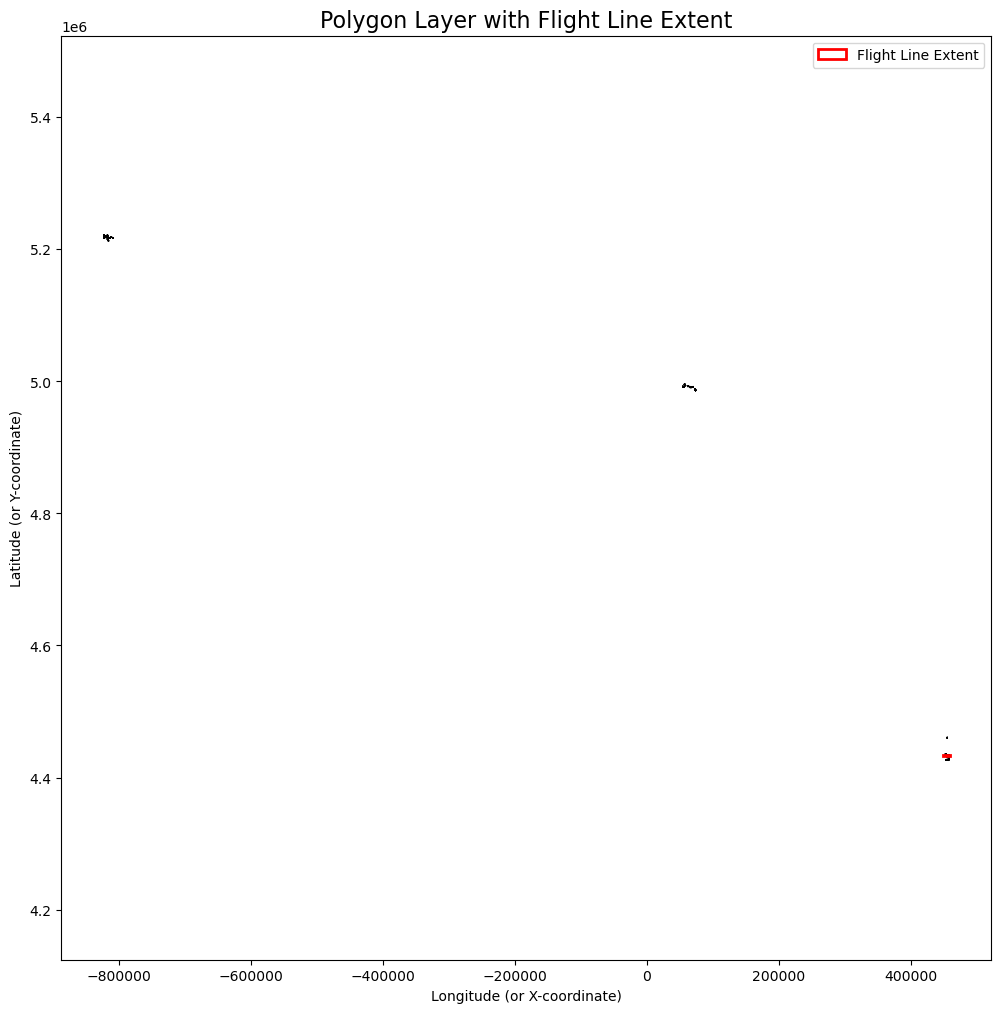

In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely.geometry import box
from matplotlib.patches import Rectangle

def plot_polygons_with_flight_line_border(envi_file, geojson_file, output_file=None):
    """
    Plots the polygon layer with the flight line raster extent as a border overlaid.

    Parameters:
    - envi_file (str): Path to the ENVI raster file.
    - geojson_file (str): Path to the GeoJSON file containing polygons.
    - output_file (str): Optional. Path to save the plot as an image.
    """
    # Load the polygon layer
    polygons = gpd.read_file(geojson_file)

    # Get the raster extent
    with rasterio.open(envi_file) as src:
        raster_crs = src.crs
        raster_bounds = box(*src.bounds)  # Convert raster bounds to a Shapely polygon

    # Ensure CRS alignment
    if polygons.crs != raster_crs:
        polygons = polygons.to_crs(raster_crs)
    
    # Plot the polygons
    fig, ax = plt.subplots(figsize=(12, 12))
    polygons.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Polygons')

    # Plot the flight line extent as a border
    flight_line_patch = Rectangle(
        (raster_bounds.bounds[0], raster_bounds.bounds[1]),  # Lower-left corner
        raster_bounds.bounds[2] - raster_bounds.bounds[0],  # Width
        raster_bounds.bounds[3] - raster_bounds.bounds[1],  # Height
        linewidth=.2, edgecolor='red', facecolor='none', label='Flight Line Extent', alpha=0.2
    )
    ax.add_patch(flight_line_patch)
    
    # Customize the plot
    ax.set_title("Polygon Layer with Flight Line Border", fontsize=16)
    ax.set_xlabel("Longitude (or X-coordinate)")
    ax.set_ylabel("Latitude (or Y-coordinate)")
    ax.legend(loc='upper right')
    ax.set_aspect('equal', adjustable='datalim')
    
    # Save or show the plot
    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()

envi_file = "non_provisional_flightlines_NIWO/NEON_D13_NIWO_DP1_20200731_151902_reflectance/NEON_D13_NIWO_DP1_20200731_151902_reflectance__envi"
geojson_file = "aop_macrosystems_data_1_7_25.geojson"
output_file = "tester_output_plot.png"  # Optional

plot_polygons_with_flight_line(envi_file, geojson_file, output_file)